In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from keras.callbacks import Callback, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

C:\Users\Saad\miniconda3\envs\looking\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Saad\miniconda3\envs\looking\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\Saad\miniconda3\envs\looking\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Loading Data
Data is loaded from images in the folder *"dataset/"*. There are two classes: *"true"* specifies images with the pedestrian using a smartphone, while *"false"* specifies images with the pedestrian not holding a smartphone. The images are loaded, shuffled and batched.

In [2]:
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)

IMAGE_DIR = "dataset/"
MODEL_NAME = "smato_efficientnet_v2m"
SAVE_DIR = f"saved_models/{MODEL_NAME}/"

In [15]:
dataset = tf.keras.utils.image_dataset_from_directory(IMAGE_DIR,
                                                      shuffle = False,
                                                      seed = 142,
                                                      batch_size = None,
                                                      image_size = IMAGE_SIZE)
CLASS_NAMES = dataset.class_names
dataset_size = len(dataset)
dataset = dataset.shuffle(buffer_size = dataset_size, seed = 142, reshuffle_each_iteration = False)
# count images in each category
counts = {
    1: 0,
    0: 0
}
for i in dataset:
    _, cls = i
    counts[int(cls)] += 1
print("Number of pedestrians with a smartphone: ", counts[1])
print("Number of pedestrians without a smartphone: ", counts[0])

# batch the dataset
dataset = dataset.batch(batch_size = BATCH_SIZE)
print("Classes: ", CLASS_NAMES)
print("Total number of batches created: ", len(dataset))

Found 13866 files belonging to 2 classes.
Number of pedestrians with a smartphone:  3770
Number of pedestrians without a smartphone:  10096
Classes:  ['false', 'true']
Total number of batches created:  217


## Splitting Dataset
The dataset is split into training, validation, and test set. 85% of the dataset is reserved for training, while the rest is divided into validation and test dataset in the ratio of 60:40.

In [16]:
# train-validation split
num_batches = len(dataset)
val_dataset = dataset.take(int(num_batches * 0.15))
train_dataset = dataset.skip(int(num_batches * 0.15))

# validation-test split
num_val_batches = len(val_dataset)
test_dataset = val_dataset.take(int(num_val_batches * 0.4))
validation_dataset = val_dataset.skip(int(num_val_batches * 0.4))

In [17]:
print("Number of batches in Training Dataset: ", len(train_dataset))
print("Number of batches in Validation Dataset: ", len(validation_dataset))
print("Number of batches in Test Dataset: ", len(test_dataset))

Number of batches in Training Dataset:  185
Number of batches in Validation Dataset:  20
Number of batches in Test Dataset:  12


In [18]:
# buffered prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

## Model Definition
A model is defined using MobileNet-V2 as the feature extractor, followed by three fully connected hidden layers. Batch Normalization is performed after each FC layer, and dropout is used to reduce overfitting.

In [9]:
# transfer learning approach - EfficientNetV2

# load model and remove the head - will act as feature extractor/image embedding
transferred = keras.applications.EfficientNetV2M(include_top = False)

# freeze all layers of the feature extractor
transferred.trainable = False

# form the keras mode
inputs = keras.Input(IMAGE_SIZE + (3, ))

x = tf.keras.applications.efficientnet_v2.preprocess_input(inputs)
x = transferred(x, training = False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.6)(x)

x = keras.layers.Dense(128)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(32)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.Dropout(0.4)(x)

x = keras.layers.Dense(8)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.Dropout(0.3)(x)

x = keras.layers.Dense(1, activation = "sigmoid")(x)

# build and show model
model = keras.Model(inputs, x, name = MODEL_NAME)
model.summary()

## Metric for choosing best model: F1 Score

In [9]:
def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall)/(precision + recall + K.epsilon())
    return f1_val

## Model Training
While training the model, only the best model is saved. This is decided by the metric accuracy on the validation set

In [11]:
model.compile(
  optimizer = tf.keras.optimizers.Adam(),
  loss = tf.keras.losses.BinaryCrossentropy(),
  metrics = ['acc', f1]
)

In [12]:
NUM_EPOCHS = 50

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = SAVE_DIR,
    save_weights_only = False,
    monitor = 'val_f1',
    mode = 'max',
    save_best_only = True
)

history = model.fit(train_dataset,
                    validation_data = validation_dataset,
                    epochs = NUM_EPOCHS,
                    callbacks = [model_checkpoint_callback])

Epoch 1/50
185/185 [==============================] - 223s 1s/step - loss: 0.2371 - acc: 0.9032 - f1: 0.8099 - val_loss: 0.1803 - val_acc: 0.9422 - val_f1: 0.8891
Epoch 2/50
185/185 [==============================] - 222s 1s/step - loss: 0.2377 - acc: 0.9042 - f1: 0.8112 - val_loss: 0.1789 - val_acc: 0.9430 - val_f1: 0.8904
Epoch 3/50
185/185 [==============================] - 228s 1s/step - loss: 0.2323 - acc: 0.9071 - f1: 0.8163 - val_loss: 0.1778 - val_acc: 0.9438 - val_f1: 0.8928
Epoch 4/50
185/185 [==============================] - 227s 1s/step - loss: 0.2301 - acc: 0.9036 - f1: 0.8096 - val_loss: 0.1772 - val_acc: 0.9469 - val_f1: 0.8984
Epoch 5/50
185/185 [==============================] - 142s 552ms/step - loss: 0.2293 - acc: 0.9084 - f1: 0.8220 - val_loss: 0.1742 - val_acc: 0.9430 - val_f1: 0.8895
Epoch 6/50
185/185 [==============================] - 142s 554ms/step - loss: 0.2348 - acc: 0.9038 - f1: 0.8114 - val_loss: 0.1742 - val_acc: 0.9461 - val_f1: 0.8966
Epoch 7/50
185/1

185/185 [==============================] - 152s 589ms/step - loss: 0.2233 - acc: 0.9116 - f1: 0.8255 - val_loss: 0.1675 - val_acc: 0.9469 - val_f1: 0.8990
Epoch 46/50
185/185 [==============================] - 152s 587ms/step - loss: 0.2211 - acc: 0.9142 - f1: 0.8348 - val_loss: 0.1700 - val_acc: 0.9453 - val_f1: 0.8957
Epoch 47/50
185/185 [==============================] - 153s 593ms/step - loss: 0.2147 - acc: 0.9161 - f1: 0.8357 - val_loss: 0.1705 - val_acc: 0.9422 - val_f1: 0.8883
Epoch 48/50
185/185 [==============================] - 154s 593ms/step - loss: 0.2291 - acc: 0.9090 - f1: 0.8233 - val_loss: 0.1720 - val_acc: 0.9445 - val_f1: 0.8926
Epoch 49/50
185/185 [==============================] - 154s 594ms/step - loss: 0.2216 - acc: 0.9141 - f1: 0.8323 - val_loss: 0.1733 - val_acc: 0.9430 - val_f1: 0.8892
Epoch 50/50
185/185 [==============================] - 154s 595ms/step - loss: 0.2174 - acc: 0.9149 - f1: 0.8330 - val_loss: 0.1697 - val_acc: 0.9469 - val_f1: 0.8982


## Model Evaluation
The best trained model is loaded and the test dataset is used for evaluating performance on data never been used in this process.

In [13]:
model = keras.models.load_model(SAVE_DIR, custom_objects = {"f1": f1})
model.evaluate(test_dataset)

12/12 [==============================] - 54s 643ms/step - loss: 0.2020 - acc: 0.9297 - f1: 0.8772


[0.20198650658130646, 0.9296875, 0.8771961331367493]

## Example Images
A bunch of images from the test dataset are chosen to show the performance of the model and to understand the reasons for misclassification.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

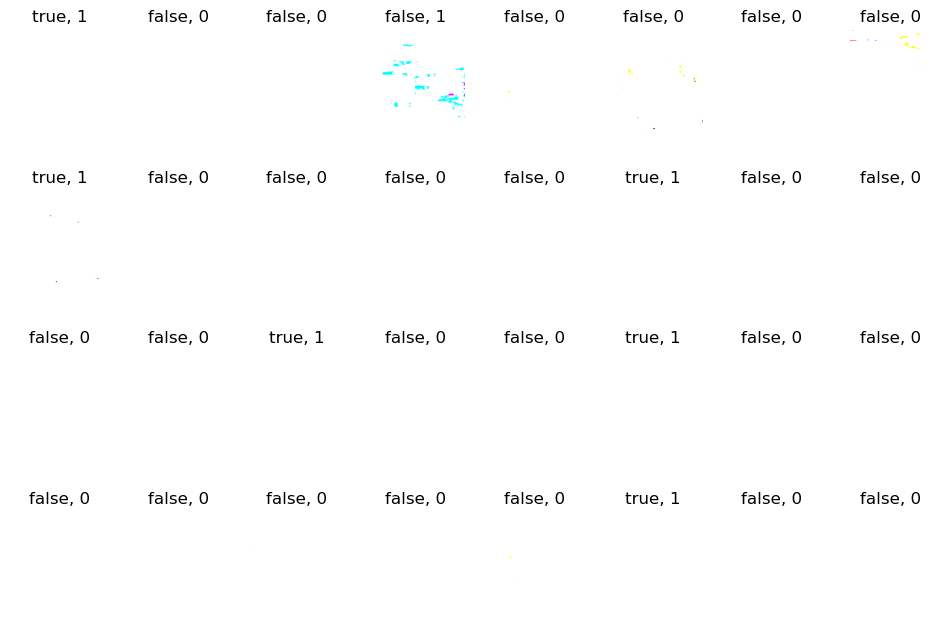

In [20]:
# # Retrieve a batch of images from the test set
# image_batch, label_batch = test_dataset.shuffle(10, seed = None).take(1).as_numpy_iterator().next()
# predictions = model.predict_on_batch(image_batch[: 32]).flatten()

# predictions = np.where(predictions < 0.5, 0, 1)
# label_batch = label_batch[: 32]

# print('Predictions:\n', predictions)
# print('Labels:\n', label_batch)

plt.figure(figsize=(12, 8))
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(image_batch[i] * 255.0)
    plt.title(str(CLASS_NAMES[predictions[i]]) + ", " + str(label_batch[i]))
    plt.axis("off")